In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
weekly = load_data('Weekly')

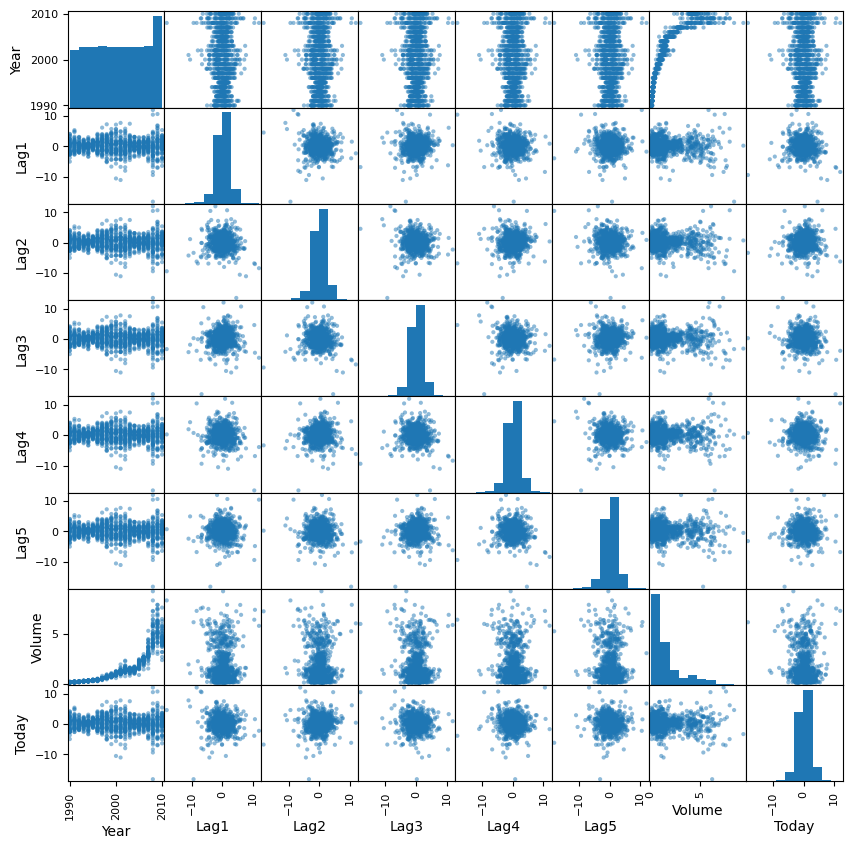

In [3]:
pd.plotting.scatter_matrix(weekly, figsize = (10,10));

In [4]:
weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


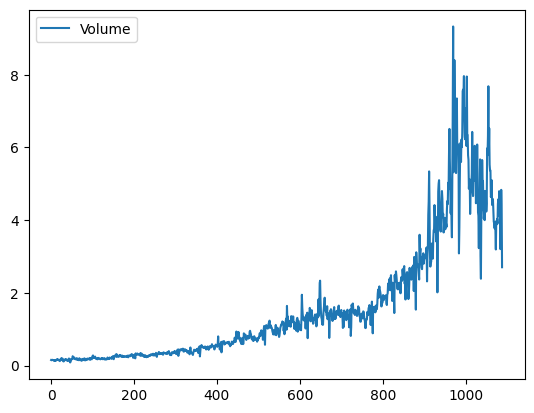

In [5]:
weekly.plot(y='Volume');

In [6]:
weekly.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [7]:
allvars = weekly.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(weekly)
y = weekly.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


In [8]:
probs = results.predict()
labels = np.array(['Down']*1089)
labels[probs>0.5] = "Up"

In [9]:
confusion_table(labels, weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [10]:
np.mean(labels == weekly.Direction)

0.5610651974288338

In [11]:
train = (weekly.Year < 2009)
weekly_train = weekly.loc[train]
weekly_test = weekly.loc[~train]
weekly_test.shape

(104, 9)

In [12]:
D = weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

In [13]:
model = MS(['Lag2']).fit(weekly)
X = model.transform(weekly)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [14]:
np.mean(labels == L_test)

0.625

In [15]:
lda = LDA(store_covariance=True)

In [16]:
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [17]:
lda.means_

array([[-0.03568254],
       [ 0.26036581]])

In [18]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [19]:
lda.priors_

array([0.44771574, 0.55228426])

In [20]:
lda.scalings_

array([[0.44141622]])

In [21]:
lda_pred = lda.predict(X_test)

In [22]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [23]:
lda_prob = lda.predict_proba(X_test)
np.all(
       np.where(lda_prob[:,1] >= 0.5, 'Up','Down') == lda_pred
       )


True

In [24]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [25]:
qda.means_, qda.priors_

(array([[-0.03568254],
        [ 0.26036581]]),
 array([0.44771574, 0.55228426]))

In [26]:
qda.covariance_[0]

array([[4.83781758]])

In [27]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [28]:
np.mean(qda_pred == L_test)

0.5865384615384616

In [29]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [30]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [31]:
NB.class_prior_

array([0.44771574, 0.55228426])

In [32]:
NB.theta_

array([[-0.03568254],
       [ 0.26036581]])

In [33]:
NB.var_

array([[4.82684748],
       [5.3608662 ]])

In [34]:
X_train[L_train == 'Down'].mean()

Lag2   -0.035683
dtype: float64

In [35]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [36]:
NB.predict_proba(X_test)[:5]

array([[0.47851874, 0.52148126],
       [0.2687286 , 0.7312714 ],
       [0.47340273, 0.52659727],
       [0.47276482, 0.52723518],
       [0.48031426, 0.51968574]])

In [37]:
knn1 = KNeighborsClassifier(n_neighbors=4)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,26,27
Up,17,34


In [38]:
np.mean(knn1_pred == L_test)

0.5769230769230769

## Question 14

In [39]:
Auto = load_data('Auto')

In [40]:
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [41]:
mpg01 = (Auto.mpg > 22.75)
Auto['mpg01'] = mpg01
Auto['mpg01'] = mpg01.astype(int)

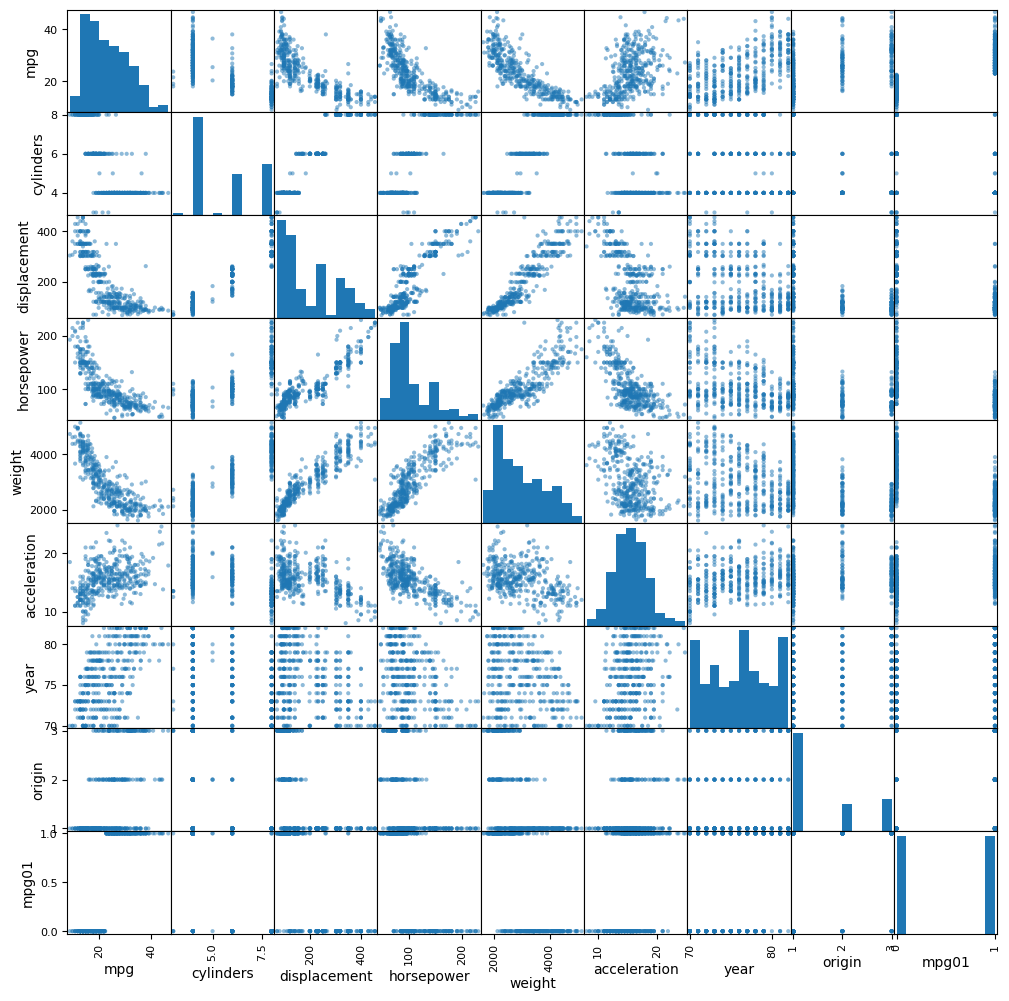

In [42]:
pd.plotting.scatter_matrix(Auto, figsize = (12,12));

In [78]:
del train
del y
del X

In [79]:
autovars = Auto.columns.drop(['mpg', 'mpg01', 'year', 'name'])
design = MS(autovars)
X = design.fit_transform(Auto)
y = Auto.mpg01 == 1
train = (Auto.year < 81)
Auto_train = Auto.loc[train]
Auto_test = Auto.loc[~train]
Auto_test.shape

(58, 10)

In [80]:
lda = LDA(store_covariance=True)

In [81]:
A = Auto.mpg01
L_train, L_test = A.loc[train], A.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
X_train, X_test = X.loc[train], X.loc[~train]

In [82]:
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [83]:
lda.means_

array([[6.78125000e+00, 2.74223958e+02, 1.30765625e+02, 3.62929167e+03,
        1.45552083e+01, 1.16666667e+00],
       [4.13380282e+00, 1.11904930e+02, 7.83943662e+01, 2.29942958e+03,
        1.65154930e+01, 2.03521127e+00]])

In [84]:
autovars

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'origin'],
      dtype='object')

In [85]:
lda.priors_

array([0.5748503, 0.4251497])

In [86]:
lda.scalings_

array([[-0.44913467],
       [ 0.00063673],
       [ 0.00179181],
       [-0.00096545],
       [-0.0141319 ],
       [ 0.28637823]])

In [87]:
lda_pred = lda.predict(X_test)

In [88]:
confusion_table(lda_pred, L_test)

Truth,0,1
Predicted,,
0,4,5
1,0,49


In [89]:
np.mean(lda_pred == L_test)

0.9137931034482759

In [90]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [91]:
qda.means_, qda.priors_

(array([[6.78125000e+00, 2.74223958e+02, 1.30765625e+02, 3.62929167e+03,
         1.45552083e+01, 1.16666667e+00],
        [4.13380282e+00, 1.11904930e+02, 7.83943662e+01, 2.29942958e+03,
         1.65154930e+01, 2.03521127e+00]]),
 array([0.5748503, 0.4251497]))

In [92]:
qda.covariance_[0]

array([[ 2.04613874e+00,  1.16635635e+02,  4.01421793e+01,
         7.91142670e+02, -2.33759817e+00, -3.97905759e-01],
       [ 1.16635635e+02,  8.12290770e+03,  2.83779622e+03,
         5.23106987e+04, -1.59332324e+02, -2.56867365e+01],
       [ 4.01421793e+01,  2.83779622e+03,  1.40046311e+03,
         1.95946289e+04, -7.72257363e+01, -4.76701571e+00],
       [ 7.91142670e+02,  5.23106987e+04,  1.95946289e+04,
         4.62533150e+05, -7.83808857e+02, -1.49247818e+02],
       [-2.33759817e+00, -1.59332324e+02, -7.72257363e+01,
        -7.83808857e+02,  7.29798320e+00,  1.41012216e-01],
       [-3.97905759e-01, -2.56867365e+01, -4.76701571e+00,
        -1.49247818e+02,  1.41012216e-01,  2.33856894e-01]])

In [93]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,0,1
Predicted,,
0,4,7
1,0,47


In [94]:
np.mean(qda_pred == L_test)

0.8793103448275862

In [95]:
autovars = Auto.columns.drop(['mpg', 'mpg01', 'year', 'name', 'cylinders', 'origin'])
design = MS(autovars)
X = design.fit_transform(Auto)
X_train, X_test = X.loc[train], X.loc[~train]
glm = sm.GLM(y_train,
             X_train,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,14.0622,3.168,4.439,0.000
displacement,-0.0168,0.006,-2.611,0.009
horsepower,-0.0603,0.024,-2.562,0.010
weight,-0.0014,0.001,-1.413,0.158
acceleration,-0.1276,0.140,-0.915,0.360


In [96]:
probs = results.predict(exog=X_test)
labels = np.array([0]*58)
labels[probs>0.5] = 1
confusion_table(labels, L_test)

Truth,0,1
Predicted,,
0,4,8
1,0,46


In [98]:
np.mean(labels == L_test)

0.8620689655172413

In [99]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [100]:
NB.class_prior_

array([0.5748503, 0.4251497])

In [101]:
NB.theta_

array([[1.00000000e+00, 2.74223958e+02, 1.30765625e+02, 3.62929167e+03,
        1.45552083e+01],
       [1.00000000e+00, 1.11904930e+02, 7.83943662e+01, 2.29942958e+03,
        1.65154930e+01]])

In [102]:
NB.var_

array([[7.59887263e-04, 8.08060164e+03, 1.39316979e+03, 4.60124124e+05,
        7.26073276e+00],
       [7.59887263e-04, 1.23139489e+03, 2.62422700e+02, 1.48558978e+05,
        6.41728042e+00]])

In [103]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,0,1
Predicted,,
0,4,6
1,0,48


In [104]:
np.mean(nb_labels == L_test)

0.896551724137931

In [153]:
knn1 = KNeighborsClassifier(n_neighbors = 270)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,0,1
Predicted,,
0,3,5
1,1,49


In [154]:
np.mean(knn1_pred == L_test)

0.896551724137931

## Question 15

In [156]:
def power():
    print(2**3)

power()

8


In [158]:
def power2(x, a):
    print(x**a)

power2(3,8)
power2(10,3)
power2(8,17)
power2(131,3)

6561
1000
2251799813685248
2248091
